In [177]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp

# constantes
SEED = 224601816
BURN_IN = 1000
THINNING = 10
SAVE = True

Sampleamos $\mu$ de una distribución semi-normal con varianza $\sigma^2=10$. Tenemos que $p(\mu)=\frac{1}{\sqrt{5\pi}}\exp\left(-\frac{\mu^2}{20}\right)$ y como $x_i\sim\mathcal N(\mu,5)$, entonces $p(x_i|\mu)=\frac{1}{\sqrt{10\pi}}\exp\left(-\frac{(x-\mu)^2}{10}\right)$

Por el teorema de Bayes, tenemos que

$$p(\mu|x_1,\ldots,x_n)=\frac{p(x_1,\ldots,x_n|\mu)p(\mu)}{p(x_1,\ldots,x_n)}=\frac{p(x_1|\mu)\cdot\ldots\cdot p(x_n|\mu)p(\mu)}{p(x_1,\ldots,x_n)}$$

In [182]:
def normal_pdf(x, mean, var):
    return np.exp( -(x - mean)**2 / (2*var)) / np.sqrt(2*np.pi*var)

prior = lambda u: 2*normal_pdf(u, mean=0, var=10) if u>0 else 0
p = lambda x, u: normal_pdf(x, mean=u, var=5)

def Metropolis_Hastings(mu_0, n_samples, burn_in=BURN_IN, thinning=THINNING):
    # Inicializamos
    mu_t = mu_0
    samples = []

    for i in range(thinning*n_samples + burn_in):
        mu_candidate = np.random.normal(mu_t, 1)
        
        # Calculamos el numerador y denominador de p(mu|x), en logaritmo
        with np.errstate(divide='ignore'):
            N = np.log(prior(mu_candidate)) + np.sum(np.log(p(x, mu_candidate)))
        D = np.log(prior(mu_t)) + np.sum(np.log(p(x, mu_t)))
        
        # Calculamos la probabilidad de aceptación
        log_accept_prob =  N - D
        
        # Comparamos con una uniforme y actualizamos
        u = np.random.uniform(0,1)
        
        if np.log(u) < log_accept_prob:
            mu_t = mu_candidate
        
        samples.append(mu_t)
    return samples, samples[burn_in::thinning]

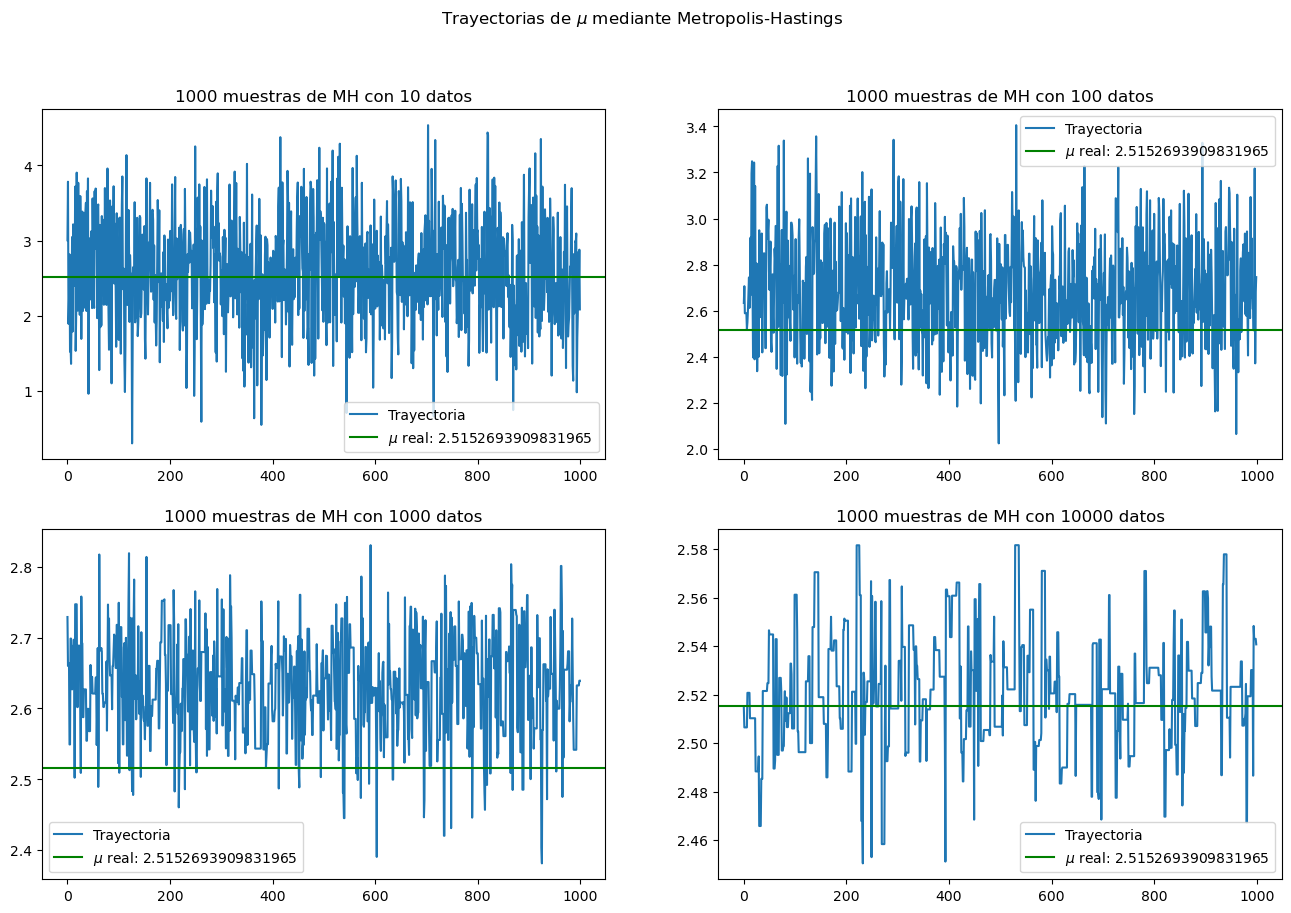

CPU times: total: 1.27 s
Wall time: 11.3 s


In [192]:
np.random.seed(SEED)

# Simulamos mu según una semi-normal
mu = np.abs(np.random.normal(loc=0, scale=np.sqrt(10)))
n = [10, 100, 1000, 10000]
m = 1000

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
plt.suptitle(f'Trayectorias de $\mu$ mediante Metropolis-Hastings')

for i, ax in enumerate(axes.flatten()):
    # Generamos datos
    x = np.random.normal(loc=mu, scale=np.sqrt(5), size=n[i])
    _, samples = Metropolis_Hastings(10, m)
  
    ax.set_title(f"{m} muestras de MH con {n[i]} datos")
    ax.plot(samples, label='Trayectoria')
    ax.axhline(mu, color='g', label=fr'$\mu$ real: {mu}')
    ax.legend()
    
if SAVE:
    plt.savefig("")
    
plt.show()